# Requirements

In [113]:
import pandas as pd
import numpy as np
import geopandas as gpd
import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

In [101]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:
conf = sddk.configure()
file_data = conf[0].get(conf[1] + "ServiceAccountsKey.json").json()
credentials = service_account.Credentials.from_service_account_info(file_data)
gc = gspread.Client(auth=credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']))
socdiv_results = gc.open_by_url("https://docs.google.com/spreadsheets/d/1kACGBS9Xdno7FL2fPZ-vCOu4SSh9uUaZmGvnEghVs_A/edit?usp=sharing")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
endpoint variable has been configured to: https://sciencedata.dk/files/


# Import dataset

In [3]:
EDHCS = pd.read_csv("../data/large_data/EDHCS_occupsorgs.csv", low_memory=False, index_col=None)
EDHCS.head(5)

,responsible_individual,type_of_inscription,letter_size,not_after,literature,work_status,height,diplomatic_text,people,depth,...,status,Latitude,Longitude,photo,Material,Comment,occups,occups_N,organizations,organizations_N
0,Feraudi,epitaph,4 cm,200.0,"AE 1983, 0080. (A); A. Ferrua, RAL 36, 1981, 1...",no image,28 cm,C SEXTIVS PARIS / QVI VIXIT / ANNIS LXX,"[{'nomen': 'Sextius', 'praenomen': 'C.', 'pers...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,[],0
1,Feraudi,honorific inscription,4.5-3 cm,170.0,"AE 1983, 0518. (B); J. González, ZPE 52, 1983,...",provisional,(37) cm,[ ]VMMIO [ ] / [ ]ISENNA[ ] / [ ] XV[ ] / [ ] / [,"[{'nomen': 'Mummius+', 'gender': 'male', 'prae...",(12) cm,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,[],0
2,Gräf,votive inscription,2.5 cm,200.0,"AE 1983, 0533. (B); A.U. Stylow, Gerión 1, 198...",checked with photo,(39) cm,[ ]AVS[ ]LLA / M PORCI NIGRI SER / DOMINAE VEN...,[{'name': '[---?]AV(?)S(?)[---]L(?)L(?)A M. Po...,18 cm,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,[],0
3,Feraudi,epitaph,NaN,200.0,"AE 1983, 0078. (B); A. Ferrua, RAL 36, 1981, 1...",no image,NaN,[ ] L SVCCESSVS / [ ] L L IRENAEVS / [ ] C L T...,"[{'person_id': '1', 'name': '[---]l. Successus...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,[],0
4,Gräf,epitaph,7-4 cm,150.0,"AE 1983, 0524. (B); P. Rodríguez Oliva - R. At...",checked with photo,145 cm,D M S / / MEMMIA AVCTIN[ ] / AN LXX PIA IN SVI...,"[{'name': 'Memmia Auctin[a]', 'nomen': 'Memmia...",15 cm,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,[],0


In [9]:
# EDHCS as geodataframe
EDHCS["geometry"] = EDHCS["geometry"].apply(eval)
EDHCSg = gpd.GeoDataFrame(EDHCS, geometry=gpd.points_from_xy(EDHCS["geometry"].apply(lambda x: x[0]), EDHCS["geometry"].apply(lambda x: x[1]))) #, crs={"init": "epsg:3857"})

# Occupations and organizations in urban vs rural context

### Buffers

In [15]:
# OCCUPATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, EDHCSg[EDHCSg["urban_context"]==context]["occups_N"].sum() / len(EDHCSg[EDHCSg["urban_context"]==context]))

big 0.036830112615573375
middle 0.029637879005604252
rest 0.01591352219291203


In [16]:
# ORGANIZATIONS frequency accross location categories
for context in ["big", "middle", "rest"]:
    print(context, EDHCSg[EDHCSg["urban_context"]==context]["organizations_N"].sum() / len(EDHCSg[EDHCSg["urban_context"]==context]))

big 0.019083300468866395
middle 0.01144201753125449
rest 0.0060786787475627935


# Bootstrap test

Brezina 2018, p. 232, drawing on Lijffijt 2016
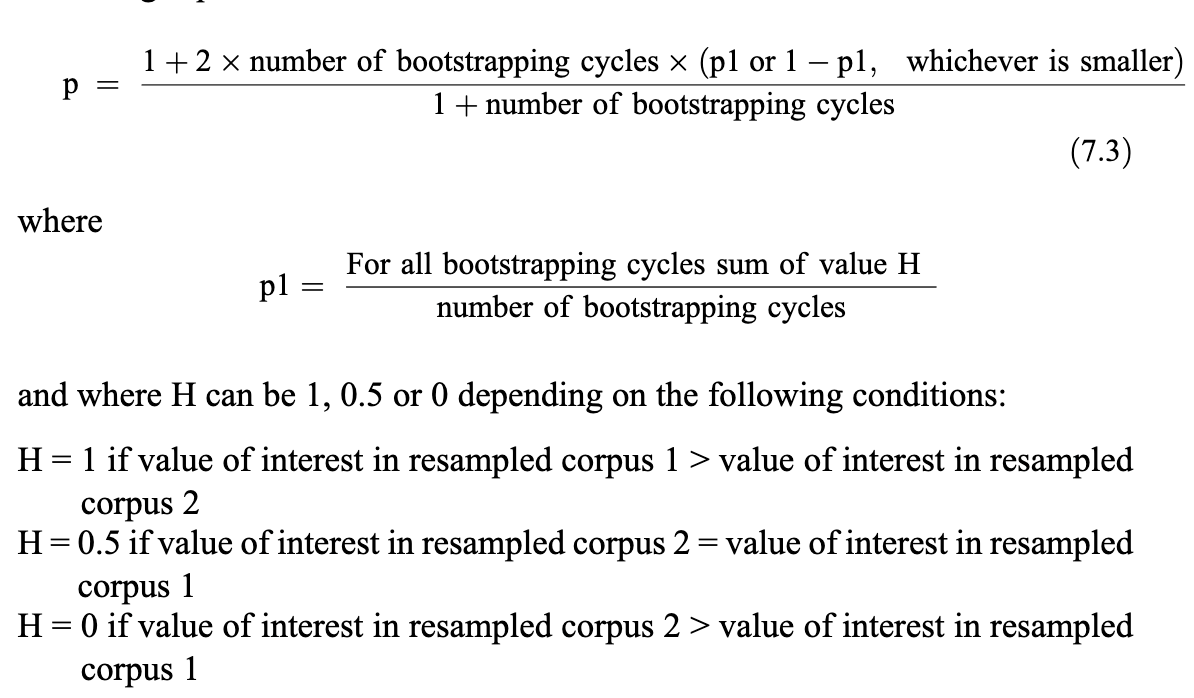

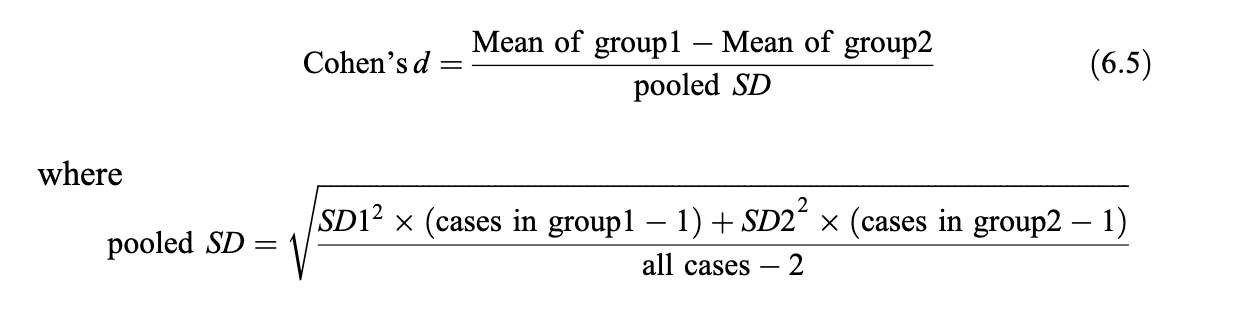

In [19]:
def get_bootstrap(df, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_values = []
    for n in range(n_of_bootstraps):
        sample_df = df.sample(bootstrap_size, replace=True)
        if row_function == None:
            bootstrap_values.append(sample_df[column].sum())
        else:
            bootstrap_values.append(sample_df[column].apply(row_function).mean())
    return bootstrap_values

def get_statistics(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    bootstrap_test_values = []
    df1_values = get_bootstrap(df1, n_of_bootstraps, bootstrap_size, column, row_function)
    df2_values = get_bootstrap(df2, n_of_bootstraps, bootstrap_size, column, row_function)
    # H values
    H_list = []
    for n in range(n_of_bootstraps):
        if df1_values[n] == df2_values[n]:
            H_list.append(0.5)
        else:
            if df1_values[n] > df2_values[n]:
                H_list.append(1)
            else:
                H_list.append(0)
    # CONFIDENCE INTERVAL (950) for the difference
    difference = np.array(df1_values) - np.array(df2_values)
    CI95 = (np.percentile(difference, 2.5), np.percentile(difference, 97.5))
    # COHENS DELTA
    pooled_sd = np.sqrt(((len(df1_values) - 1) * ((np.std(df1_values)**2))) + ((len(df2_values) - 1) * (np.std(df2_values)**2)) / (len(df1_values) + len(df2_values) + 2))
    cohens_delta = (np.mean(df1_values) - np.mean(df2_values)) / pooled_sd
    return H_list, cohens_delta, CI95, [df1_values, df2_values]

def bootstrap_test(df1, df2, n_of_bootstraps, bootstrap_size, column, row_function=None):
    H_values, cohens_delta, CI95, data = get_statistics(df1, df2, 1000, 1000, "occups_N", row_function)
    p1 =  sum(H_values) / len(H_values)
    p = (1 + (2 * len(H_values) * np.min((p1, 1 - p1)))) / (1 + len(H_values))
    return p, cohens_delta, CI95, data

In [20]:
# test1 "get_bootstrap()"
df1_values = get_bootstrap(EDHCSg[EDHCSg["urban_context"]=="big"], 1000, 1000, "occups_N")
df2_values = get_bootstrap(EDHCSg[EDHCSg["urban_context"]=="middle"], 1000, 1000, "occups_N")

print(df1_values[:10])
print(df2_values[:10])

[46, 36, 31, 35, 45, 39, 38, 26, 39, 50]
[44, 27, 32, 28, 33, 22, 22, 34, 26, 28]


### Occupations

In [28]:
# EDHCS - occupations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_occups_big_middle = bootstrap_test(EDHCSg[EDHCSg["urban_context"]=="big"], EDHCSg[EDHCSg["urban_context"]=="middle"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.4365634365634365, 0.029236966766143548, (-13.0, 28.0))

In [29]:
# EDHCS - occuptions in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_occups_middle_rest = bootstrap_test(EDHCSg[EDHCSg["urban_context"]=="middle"], EDHCSg[EDHCSg["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.06393606393606388, 0.06695071312639056, (-1.0, 30.0))

In [30]:
# EDHCS - occupations in BIG CITIES vs REST areas
p, cohens_d, CI95, edhcs_data_occups_big_rest = bootstrap_test(EDHCSg[EDHCSg["urban_context"]=="big"], EDHCSg[EDHCSg["urban_context"]=="rest"], 1000, 1000, "occups_N")
p, cohens_d, CI95

(0.012987012987012998, 0.08114668908837497, (3.0, 41.0))

### Organizations

In [33]:
# EDHCS - organizations in BIG CITIES vs MIDDLE CITIES
p, cohens_d, CI95, edhcs_data_orgs_big_middle = bootstrap_test(EDHCSg[EDHCSg["urban_context"]=="big"], EDHCSg[EDHCSg["urban_context"]=="middle"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.42057942057942055, 0.031031317399246607, (-10.024999999999999, 29.0))

In [34]:
# EDHCS - organizations in MIDDLE CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_middle_rest = bootstrap_test(EDHCSg[EDHCSg["urban_context"]=="middle"], EDHCSg[EDHCSg["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.10389610389610388, 0.06446543818792377, (-2.0, 30.0))

In [36]:
# EDHCS - organizations in BIG CITIES vs. REST areas
p, cohens_d, CI95, edhcs_data_orgs_big_rest = bootstrap_test(EDHCSg[EDHCSg["urban_context"]=="big"], EDHCSg[EDHCSg["urban_context"]=="rest"], 1000, 1000, "organizations_N")
p, cohens_d, CI95

(0.014985014985014998, 0.0863933806333612, (4.0, 38.0))

In [185]:
labels=[
    "cities (pop.≥30K)",
    "cities (pop.>1K)",
    "rural or minor cities"
]

In [198]:
stat_series = []
for label, data in zip(labels, edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    
for label, data in zip(labels, edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]]):
    stat_series.append(pd.Series(data).describe())
    

In [203]:
contexts = labels + labels
contexts  = [context.replace("\n", " ") for context in contexts]
measurements = ["occups. per 1,000 ins."] * 3 + ["orgs. per 1,000 ins."] * 3

occups_orgs_contexts_descriptive = pd.DataFrame([measurements, contexts], index=["measurement","context"]).T.join(pd.DataFrame(stat_series))

for col in ["count",  "min", "25%", "50%", "75%", "max"]:
    occups_orgs_contexts_descriptive[col] = occups_orgs_contexts_descriptive[col].astype(int)
occups_orgs_contexts_descriptive.drop("count", inplace=True, axis=1)
#occups_orgs_contexts_descriptive.rename(columns={"count" : "N of bootstraps"}, inplace=True)
occups_orgs_contexts_descriptive = occups_orgs_contexts_descriptive.round(2)
occups_orgs_contexts_descriptive

,measurement,context,mean,std,min,25%,50%,75%,max
0,"occups. per 1,000 ins.",cities (pop.≥30K),36.82,7.84,15,31,36,42,68
1,"occups. per 1,000 ins.",cities (pop.>1K),29.58,6.36,12,25,29,34,56
2,"occups. per 1,000 ins.",rural or minor cities,15.86,4.68,3,13,15,19,34
3,"orgs. per 1,000 ins.",cities (pop.≥30K),37.26,7.80,18,32,36,42,69
4,"orgs. per 1,000 ins.",cities (pop.>1K),29.61,6.19,14,25,29,34,54
5,"orgs. per 1,000 ins.",rural or minor cities,15.75,5.00,4,12,15,19,41


In [204]:
print(occups_orgs_contexts_descriptive.to_latex(index=False, bold_rows=True, multirow=True))

\begin{tabular}{llrrrrrrr}
\toprule
            measurement &                context &   mean &   std &  min &  25\% &  50\% &  75\% &  max \\
\midrule
 occups. per 1,000 ins. &      cities (pop.≥30K) &  36.82 &  7.84 &   15 &   31 &   36 &   42 &   68 \\
 occups. per 1,000 ins. &       cities (pop.>1K) &  29.58 &  6.36 &   12 &   25 &   29 &   34 &   56 \\
 occups. per 1,000 ins. &  rural or minor cities &  15.86 &  4.68 &    3 &   13 &   15 &   19 &   34 \\
   orgs. per 1,000 ins. &      cities (pop.≥30K) &  37.26 &  7.80 &   18 &   32 &   36 &   42 &   69 \\
   orgs. per 1,000 ins. &       cities (pop.>1K) &  29.61 &  6.19 &   14 &   25 &   29 &   34 &   54 \\
   orgs. per 1,000 ins. &  rural or minor cities &  15.75 &  5.00 &    4 &   12 &   15 &   19 &   41 \\
\bottomrule
\end{tabular}



In [188]:
occups_orgs_contexts_descriptive.to_csv("../data/occups_orgs_contexts_descriptive.csv")

In [107]:
# export to google sheets
set_with_dataframe(socdiv_results.add_worksheet("occups_orgs_contexts_descriptive", 1,1), occups_orgs_contexts_descriptive)

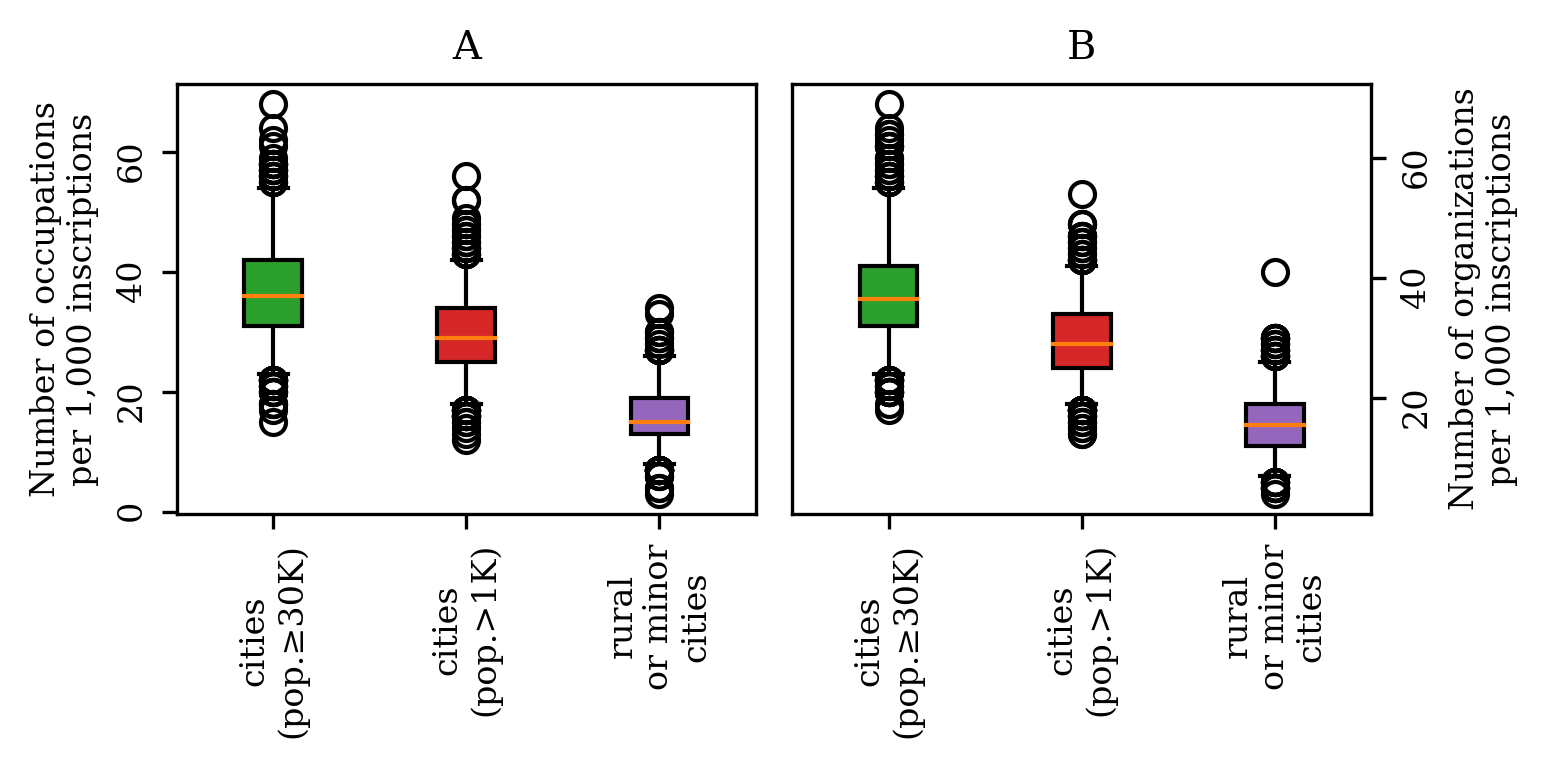

In [205]:

plt.style.use("fast")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]

fig, [ax1, ax2] = plt.subplots(1,2, figsize=[5.2,2.6], tight_layout=True)

bplot1 = ax1.boxplot(edhcs_data_occups_big_middle + [edhcs_data_occups_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax1.set_title("A")
ax1.set_ylabel("Number of occupations\nper 1,000 inscriptions")
ax1.tick_params(labelrotation=90)



bplot2 = ax2.boxplot(edhcs_data_orgs_big_middle + [edhcs_data_orgs_middle_rest[1]], whis=[2.5, 97.5], labels=labels, patch_artist=True)
ax2.set_title("B")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_ylabel("Number of organizations\nper 1,000 inscriptions")
ax2.tick_params(labelrotation=90)



# fill with colors
colors =tab_colors_list[2:][:len(labels)]
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

In [206]:
fig.savefig("../figures/occups_orgs_by_context_box.eps", format="eps", dpi=300)

# By industry type

In [109]:
# generate a dictionary of occupations by type
occupations_df = pd.read_csv("../data/occupations_list.csv")
occups_cats_dict = dict(zip(occupations_df["Term"], occupations_df["Category"]))

In [123]:
def cat_for_occup(list_of_occups):
    try:
        return [occups_cats_dict[occup] for occup in eval(list_of_occups)]
    except:
        return []
    
EDHCSg["occups_cats"] = EDHCSg["occups"].apply(cat_for_occup)

In [175]:
edhcs_occups_cats_data = {}

labels=[
    "cities\n(pop.≥30K)",
    "cities\n(pop.>1K)",
    "rural\nor minor\ncities"
]


edhcs_all_present_categories = []
for df_subset, subset_title in zip([EDHCSg[EDHCSg["urban_context"]=="big"], EDHCSg[EDHCSg["urban_context"]=="middle"], EDHCSg[EDHCSg["urban_context"]=="rest"]], labels):
    occups_cats_list = [el for sublist in df_subset["occups_cats"].tolist() for el in sublist]
    wordcount = df_subset["clean_text_interpretive_word"].astype("str").apply(lambda x: len(x.split())).sum()
    occups_cats_dist = nltk.FreqDist(occups_cats_list).most_common()
    categories = [tup[0] for tup in occups_cats_dist]
    edhcs_all_present_categories.extend(categories[:10])
    freqs = [(tup[1] / wordcount) * 10000 for tup in occups_cats_dist]
    cat_freq_dict = dict(zip(categories[:10], freqs[:10]))
    total_freq = np.sum(freqs)
    edhcs_occups_cats_data[subset_title] = {"categories" : categories, "freqs" : freqs, "cat_freq_dict" : cat_freq_dict,"total_freq" : total_freq}
    print(categories, freqs, total_freq)
edhcs_all_present_categories = list(set(edhcs_all_present_categories))

['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Building', 'Education', 'Food-Production', 'Retail', 'Clothing', 'Transport', 'Performing Arts', 'Finance', 'Food-Retail', 'Household Goods', 'Plastic Arts', 'Water-Management', 'Glass-Working', 'Unclear meaning', 'Fuel / Raw material'] [5.7179035016772515, 5.519019901618912, 4.309144667930682, 2.0882778006125613, 1.8893942005542221, 1.6739369671576882, 1.5744951671285186, 1.5413479004521287, 0.9446971002771111, 0.6629453335277973, 0.5137826334840428, 0.39776720011667843, 0.3811935667784835, 0.3480463001020936, 0.16573633338194932, 0.08286816669097466, 0.03314726667638986, 0.01657363333819493] 27.86027764150568
['Metal-Working', 'Miscellaneous Services', 'Managerial', 'Retail', 'Building', 'Performing Arts', 'Education', 'Clothing', 'Food-Production', 'Transport', 'Finance', 'Plastic Arts', 'Household Goods', 'Food-Retail', 'Water-Management', 'Unclear meaning', 'Glass-Working'] [9.647720802287365, 3.5873645388252067, 2.3813994

In [176]:
edhcs_data_by_category = {}
for cat in edhcs_all_present_categories:
    cat_data = []
    for label in labels:
        try:
            cat_data.append(edhcs_occups_cats_data[label]["cat_freq_dict"][cat])
        except:
            cat_data.append(0)
    edhcs_data_by_category[cat] = cat_data
edhcs_data_by_category

{'Metal-Working': [5.7179035016772515, 9.647720802287365, 4.703444420965092],
 'Building': [2.0882778006125613, 1.6181303877254123, 1.1360976862234522],
 'Clothing': [1.5413479004521287, 0.931188241992926, 0.3862732133159738],
 'Food-Production': [1.6739369671576882,
  0.7174729077650415,
  0.522604935662788],
 'Education': [1.8893942005542221, 1.3280881484161404, 0.5680488431117261],
 'Retail': [1.5744951671285186, 1.7249880548393548, 0.6816586117340713],
 'Performing Arts': [0.6629453335277973,
  1.373884291464973,
  0.4771610282138499],
 'Miscellaneous Services': [5.519019901618912,
  3.5873645388252067,
  2.1358636501000903],
 'Managerial': [4.309144667930682, 2.3813994385392863, 1.2269855011213284],
 'Transport': [0.9446971002771111, 0.5648190976022667, 0.43171712076491187]}

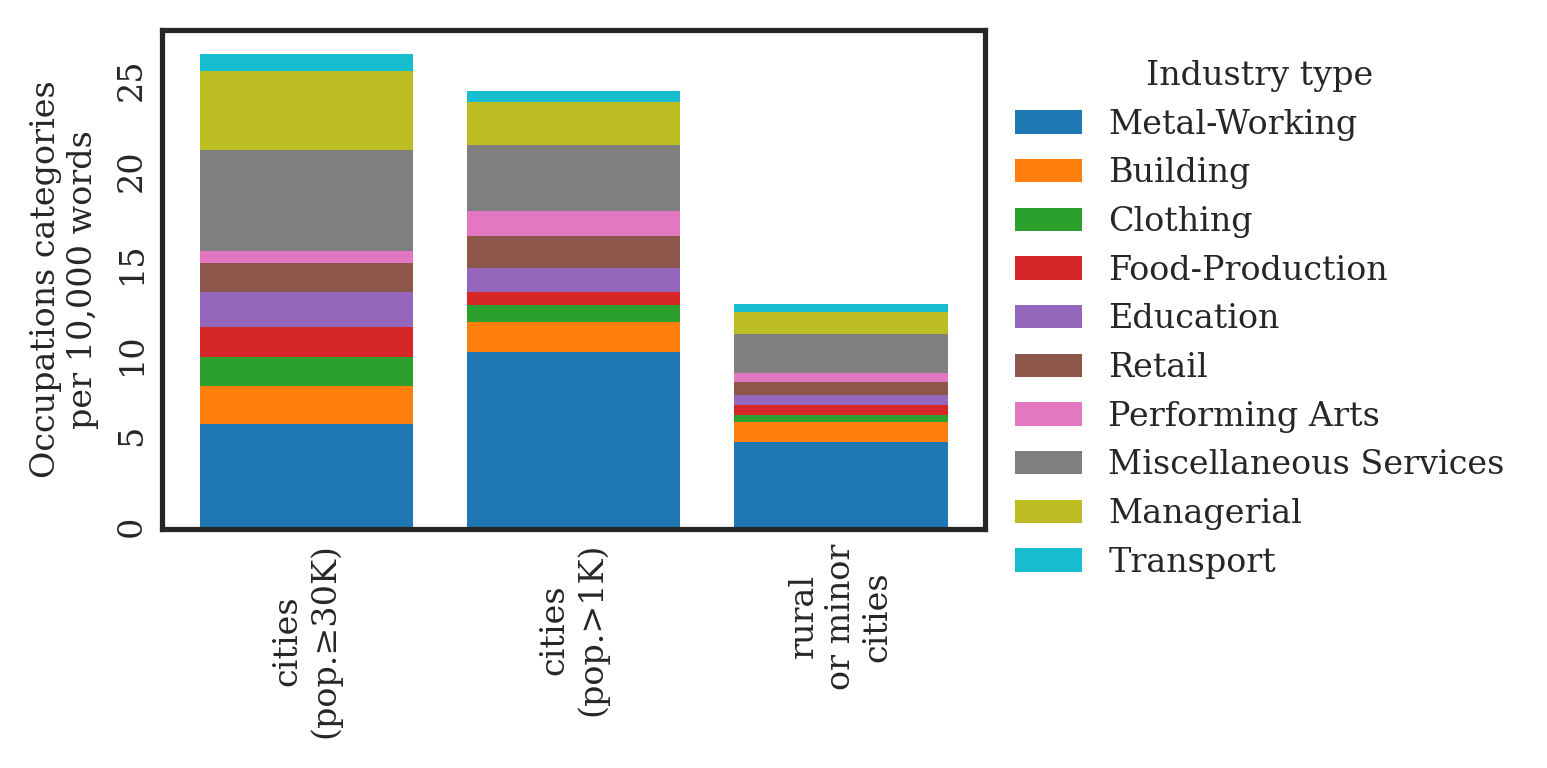

In [207]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.size'] = 8

fig, ax = plt.subplots(figsize=[5.2,2.6], tight_layout=True)
first_bar_cat = list(edhcs_data_by_category.keys())[0]
ax.bar(labels, edhcs_data_by_category[first_bar_cat], label=first_bar_cat)
bottom = edhcs_data_by_category[first_bar_cat]

ax.tick_params(labelrotation=90)

for cat in list(edhcs_data_by_category.keys())[1:]:
    ax.bar(labels, edhcs_data_by_category[cat], bottom = bottom, label=cat)
    bottom += np.array(edhcs_data_by_category[cat])
ax.set_ylabel("Occupations categories\nper 10,000 words")
ax.legend(title="Industry type", bbox_to_anchor=(1, 1), fontsize=8)

In [208]:
fig.savefig("../figures/occups_industrytypes_context_bar.eps", format="eps", dpi=300)